## Make dinosaur cards

In [1]:
import PIL

In [2]:
from PIL import Image
import numpy as np

In [3]:
from glob import glob

In [4]:
import re

In [5]:
from PIL import ImageOps
from io import BytesIO
import base64

## Get properties about the cards

In [6]:
card_path_str = './static/better_cards/'
path_to_cards = glob(card_path_str+'*.png')

In [7]:
BORDER_WIDTH = 30
CORNER_HEIGHT = 250
CORNER_WIDTH = 78
OUTPUT_SIZE = (338//3,489//3)

In [8]:
back = Image.open(card_path_str + 'green_back.png')
CARD_SIZE = back.size
SHORT_SIDE = CARD_SIZE[0]
LONG_SIDE = CARD_SIZE[1]
PROPORTIONS = back.size[0]/back.size[1]

## Utility functions

In [9]:
def remove_card_icon(card, leave_value=True):
    if leave_value:
        width = CORNER_WIDTH
        height = CORNER_HEIGHT
    else:
        height=0
        width=0
    replacement_dimensions = (LONG_SIDE-height-2*BORDER_WIDTH, SHORT_SIDE-width-2*BORDER_WIDTH, 3)
    card[BORDER_WIDTH+height:-BORDER_WIDTH, BORDER_WIDTH:-width-BORDER_WIDTH, 0:3] = np.ones(replacement_dimensions)*255
    card[BORDER_WIDTH:-height-BORDER_WIDTH, BORDER_WIDTH+width:-BORDER_WIDTH, 0:3] = np.ones(replacement_dimensions)*255

    return card

In [10]:
def get_boring_card_as_np(path):
    raw_card = Image.open(path)
    raw_card = raw_card.convert('RGBA')
    if raw_card.size != CARD_SIZE:
        raw_card = raw_card.resize(CARD_SIZE)
    np_card = np.asarray(raw_card).copy()
    return np_card

In [11]:
def get_corresponding_dino(card_path):
    card_value_pattern = '.*/(?P<value>.*)(?P<suit>[A-Z])\.png'
    regex_result = re.search(card_value_pattern, card_path)
    
    if not regex_result:
        return None
    
    value = regex_result.group('value')
    dino_path = f"./static/dino_cards/d{value}.png"
    dino = Image.open(dino_path)
    return dino

In [68]:
def shape_to_fit(image):
    # resize to square in short dimension
    replacement_dimensions = (SHORT_SIDE-2*CORNER_WIDTH, LONG_SIDE-2*CORNER_HEIGHT)
    image = image.resize((SHORT_SIDE-2*CORNER_WIDTH, SHORT_SIDE-2*CORNER_WIDTH))
    
    # pad with white
    image_shaped = ImageOps.pad(image, replacement_dimensions, color=(255,255,255))
#     delta_height = replacement_dimensions[0] - image.size[0]
#     padding = (0, delta_height//2, 0, delta_height - delta_height//2)
#     image_shaped = ImageOps.expand(image, padding)
#     rgba = np.asarray(image_shaped).copy()
#     rgba[:,:,3] = 255
#     image_shaped = Image.fromarray(rgba)
    return image_shaped

## Make a card back

In [69]:
def make_card_size(im):
    im = im.crop((0, 0, im.size[0]*PROPORTIONS, im.size[0]))
    im = im.convert('RGBA')
    return im.resize(CARD_SIZE) 

We create a card template. This is transparent around the outside of the card, and white inside the card. Non-white pixels are the border.

In [70]:
new_card_np = get_boring_card_as_np(card_path_str+'2S.png')
card_template = remove_card_icon(new_card_np, leave_value=False)

This template can be used to add a border to any card

In [71]:
def add_border(np_im):
    np_im[card_template[:, :, 2]<255, 0] = 0
    np_im[card_template[:, :, 2]<255, 1] = 0
    np_im[card_template[:, :, 2]<255, 2] = 0
    return np_im

To make our card back, we start with the full image of the dino scene, and we re-size and crop until it matches the card size. 

In [72]:
dino_back = Image.open('./static/dino_cards/background.jpg')
dino_back_scaled = make_card_size(dino_back)
dino_back_np = np.asarray(dino_back_scaled).copy()

Now we take our dino pattern, and make the edges transparent, in the same way as the template.

In [73]:
dino_back_np[card_template[:, :, 3]==0, 3] = 0

Now we get all the border pixels and colour them black. 

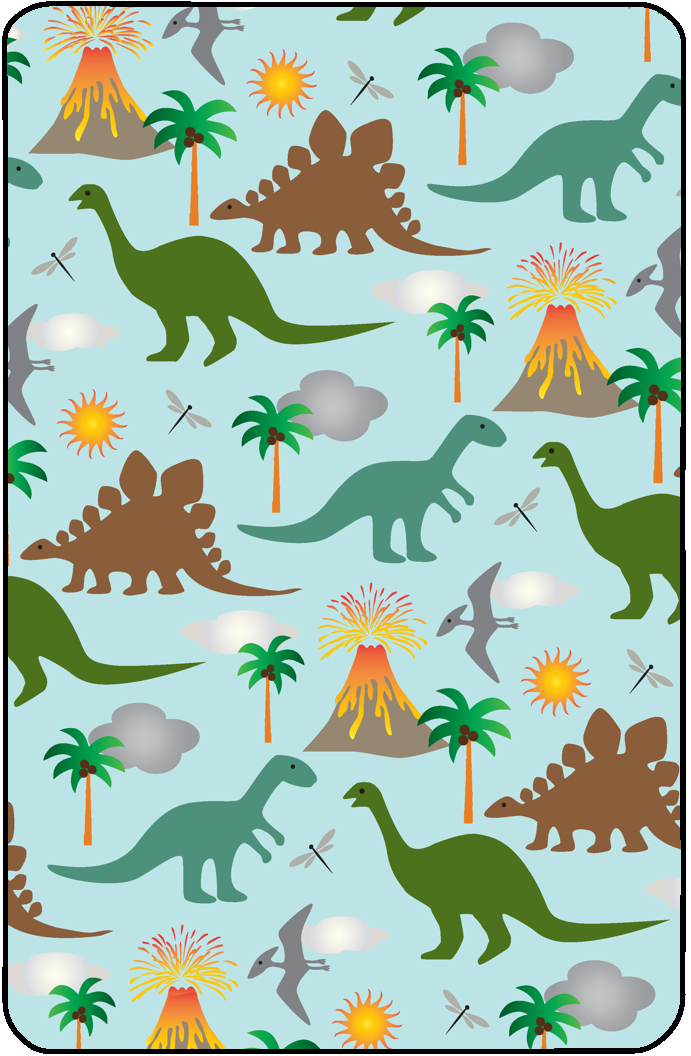

In [74]:
dino_back_np = add_border(dino_back_np)
Image.fromarray(dino_back_np)

## Make a joker

In [75]:
joker_base = Image.open('./static/better_cards/joker.png')
joker_np = np.asarray(joker_base).copy()

joker_dino = Image.open('./static/dino_cards/dred.png')
joker_dino = shape_to_fit(joker_dino)
joker_dino = np.asarray(joker_dino).copy()

In [76]:
joker_np[CORNER_HEIGHT:-CORNER_HEIGHT, CORNER_WIDTH:-CORNER_WIDTH, :] = joker_dino
joker_np = add_border(joker_np)

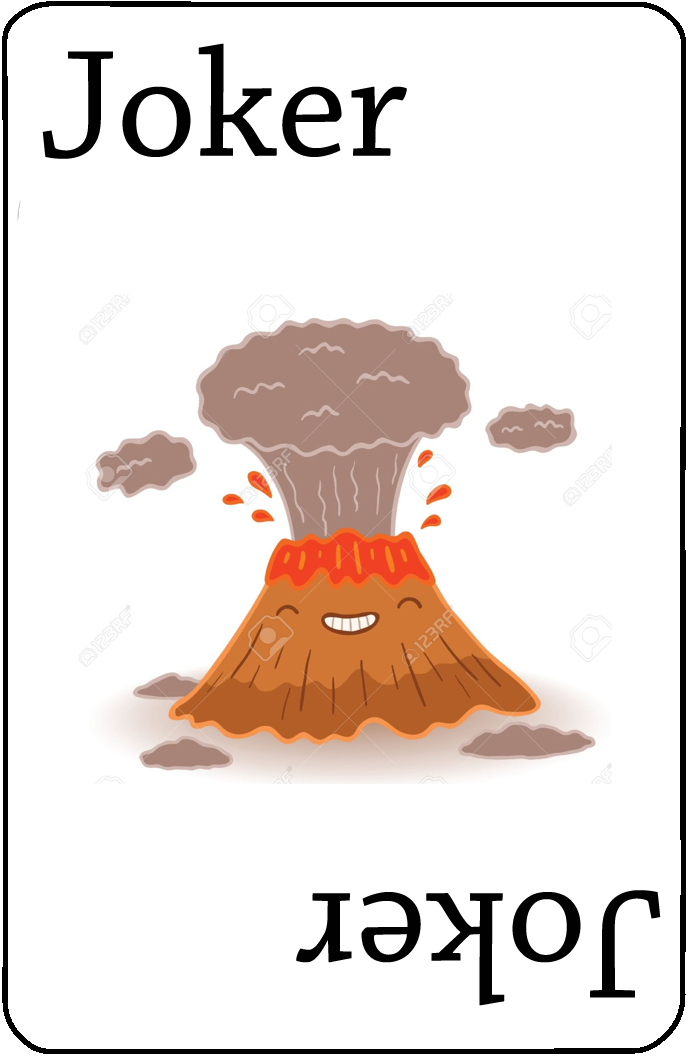

In [77]:
joker_card = Image.fromarray(joker_np)
joker_card

## Convert all the card fronts

In [78]:
def new_file_name(old_file_name):
    card_value_pattern = '.*/(?P<value>.*)(?P<suit>[A-Z])\.png'
    regex_result = re.search(card_value_pattern, old_file_name)
    
    if regex_result is None:
        return old_file_name

    value = regex_result.group('value')
    suit = regex_result.group('suit')
    
    suit_map = {'S': 'spade', 'D': 'diamond', 'H': 'heart', 'C': 'club'}
    value_map = {'J': 'jack', 'Q': 'queen', 'K': 'king', 'A': '1'}
    
    new_name = f"{suit_map[suit]}_{value_map[value] if value in value_map else value}"
    return new_name

In [79]:
def write_card(card_image, card_path):
    card_image = card_image.resize(OUTPUT_SIZE)
    buffered = BytesIO()
    card_image.save(buffered, format="PNG")
    b64_str = str(base64.b64encode(buffered.getvalue()))[2:-1]
    
    output_file.write(new_file_name(card_path))
    output_file.write(': "')
    output_file.write(b64_str)
    output_file.write('",\n')

In [80]:
output_file = open('./static/dinoCardData.js', 'w+')
_ = output_file.write("var cardData = {\n")

In [81]:
for card_path in path_to_cards:
    new_card_np = get_boring_card_as_np(card_path)
    dino = get_corresponding_dino(card_path)
    
    if not dino:
        continue

    new_card = remove_card_icon(new_card_np)
    fitted_dino = shape_to_fit(dino)
    new_card[CORNER_HEIGHT:-CORNER_HEIGHT, CORNER_WIDTH:-CORNER_WIDTH, :] = fitted_dino
    new_card = add_border(new_card)
    new_card_image = Image.fromarray(new_card)

    new_card_image.save(f'./static/dino_cards/output/{new_file_name(card_path)}.png')
#     display(Image.fromarray(new_card))
    write_card(new_card_image, card_path)

write_card(Image.fromarray(dino_back_np), "back")
write_card(joker_card, "joker")

In [82]:
output_file.write('}')
output_file.close()